In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [34]:
def fill_correct(df, half_scores = False):
    df = df.copy()
    if half_scores:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right'
            else 0.5 if str(x).strip().lower() == 'somewhat right' 
            else 0
            )
    else:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right' 
            else 0
        )
    return df

def clean_df(df, subset_cols,):
    df = df.copy()
    df = df.dropna(subset=subset_cols).drop_duplicates(subset=subset_cols, keep='last')
    return df

def prepare_df(df, half_scores = False):
    df = df.copy()
    df = fill_correct(df, half_scores=half_scores)
    ensemble_subset_cols = [
            "problem_id",
            "dataset_name",
            "type_name",
            "version",
        ]
    
    single_subset_cols = [
            "problem_id",
            "dataset_name",
            "model_name",
            "strategy_name",
            "version"
        ]
    df_singles = df[df["ensemble"] == False]
    df_singles = clean_df(df_singles, subset_cols=single_subset_cols)
    df_ensembles = df[df["ensemble"] == True]
    df_ensembles = clean_df(df_ensembles, subset_cols=ensemble_subset_cols)
    return df_singles, df_ensembles

In [ ]:
df = pd.read_csv('results/all_results_concat.csv')
df = prepare_df(df, half_scores=True)[0]

## Top models

In [56]:
def accuracy_stats(
    df,
    group_cols,
    versions=(1, 3),
    top_n=None,
    bottom_n=None
):

    df = df.copy()

    # Filter versions
    df = df[df["version"].isin(versions)]

    # Group and aggregate
    grouped = df.groupby(group_cols)["is_correct"]

    score = grouped.sum()
    total = grouped.count()

    percentage = score / total * 100

    results = pd.DataFrame({
        "total_score": score,
        "percentage": percentage
    }).reset_index()

    accuracy_stats = results.sort_values("percentage", ascending=False)
    # Sort
    if top_n is not None:
        top = results.sort_values("percentage", ascending=False).head(top_n)
        print(f"\nTop {top_n}:")
        print(top)
    
    if bottom_n is not None:
        bottom = results.sort_values("percentage", ascending=True).head(bottom_n)
        print(f"\nBottom {bottom_n}:")
        print(bottom)

    # ---- Top K list in requested format ----
    # top_k_list = [
    #     [str(row[col]) for col in group_cols]
    #     for _, row in accuracy_stats.head(top_n).iterrows()
    # ]

    # print(f"\nTop {top_n} {[f'{c}' for c in group_cols]}:")
    # print(top_k_list)

    return accuracy_stats


In [ ]:
group_cols = ["strategy_name", "model_name", "version"]
accuracy_stats(df, group_cols=group_cols)

bp_only = df[df["dataset_name"]=="bp"].copy()
bp_only = bp_only[bp_only["strategy_name"]!="classification"]
cvr_only = df[df["dataset_name"]=="cvr"].copy()
raven_only = df[df["dataset_name"]=="raven"].copy()
mars_only = df[df["dataset_name"]=="marsvqa"].copy()

group_cols.append("dataset_name")
print("\n ------------ BP -------------\n")
accuracy_stats(bp_only, group_cols=group_cols, top_n=5, bottom_n=5)
print("\n ------------ CVR -------------\n")
accuracy_stats(cvr_only, group_cols=group_cols, top_n=5, bottom_n=5)
print("\n ------------ RAVEN -------------\n")
accuracy_stats(raven_only, group_cols=group_cols, top_n=5, bottom_n=5)
print("\n ------------ MARS -------------\n")
accuracy_stats(mars_only, group_cols=group_cols, top_n=5, bottom_n=5)

In [59]:
def select_top(df, acc_group_cols, top_group_cols):
    df = df.copy()
    df = accuracy_stats(df, acc_group_cols)

    top_df = (
        df
        .sort_values("percentage", ascending=False)
        .groupby(top_group_cols)
        .first()
        .reset_index()
    )

    return top_df

In [60]:
acc_group_cols = ["strategy_name", "model_name", "version"]
top_group_cols = ["model_name", "strategy_name"]
select_top(df, acc_group_cols, top_group_cols)

,model_name,strategy_name,version,total_score,percentage
0,OpenGVLab/InternVL3-8B,classification,1,114.0,28.500
1,OpenGVLab/InternVL3-8B,contrastive,3,106.0,26.500
2,OpenGVLab/InternVL3-8B,descriptive,1,124.0,31.000
3,OpenGVLab/InternVL3-8B,direct,1,126.0,31.500
4,Qwen/Qwen2.5-VL-7B-Instruct,classification,1,122.0,30.500
5,Qwen/Qwen2.5-VL-7B-Instruct,contrastive,3,193.0,48.250
6,Qwen/Qwen2.5-VL-7B-Instruct,descriptive,3,115.5,28.875
7,Qwen/Qwen2.5-VL-7B-Instruct,direct,3,196.0,49.000
8,llava-hf/llava-v1.6-mistral-7b-hf,classification,3,104.0,26.000
9,llava-hf/llava-v1.6-mistral-7b-hf,contrastive,3,93.5,23.375


In [ ]:
top_group_cols = ["strategy_name", "model_name"]
select_top(df, acc_group_cols, top_group_cols)

,strategy_name,model_name,version,total_score,percentage
0,classification,OpenGVLab/InternVL3-8B,1,114.0,28.500
1,classification,Qwen/Qwen2.5-VL-7B-Instruct,1,122.0,30.500
2,classification,llava-hf/llava-v1.6-mistral-7b-hf,3,104.0,26.000
3,contrastive,OpenGVLab/InternVL3-8B,3,106.0,26.500
4,contrastive,Qwen/Qwen2.5-VL-7B-Instruct,3,193.0,48.250
5,contrastive,llava-hf/llava-v1.6-mistral-7b-hf,3,93.5,23.375
6,descriptive,OpenGVLab/InternVL3-8B,1,124.0,31.000
7,descriptive,Qwen/Qwen2.5-VL-7B-Instruct,3,115.5,28.875
8,descriptive,llava-hf/llava-v1.6-mistral-7b-hf,3,102.0,25.500
9,direct,OpenGVLab/InternVL3-8B,1,126.0,31.500


## Matrices

### Plotting

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import pandas as pd
import numpy as np


def generate_10x10_result_matrix(
    df,
    dataset_name=None,
    model_name=None,
    strategy_name=None,
    type_name=None,
    versions=None,
    zero_indexed_problem_ids=False
):
    df = df.copy()

    filters = {
        "dataset_name": dataset_name,
        "model_name": model_name,
        "strategy_name": strategy_name,
        "type_name": type_name,
        "version": versions,
    }

    for col, val in filters.items():
        if val is not None:
            df = df[df[col] == val]

    scores = (
        df.groupby("problem_id")["is_correct"]
        .sum()
    )

    offset = 0 if zero_indexed_problem_ids else 1

    matrix = pd.DataFrame(0, index=range(10), columns=range(10))

    for pid, score in scores.items():
        adj = pid - offset
        row, col = divmod(adj, 10)
        if 0 <= row < 10 and 0 <= col < 10:
            matrix.iloc[row, col] = score

    matrix.index = [f"{i*10+1}-{i*10+10}" for i in range(10)]
    matrix.columns = [f"{i+1}" for i in range(10)]

    return matrix


def plot_10x10_matrices_side_by_side(
    matrices,
    titles,
    max_score,
    main_title,
    highlight_extremes=False,
    zero_indexed_problem_ids=False
):
    assert len(matrices) == len(titles) <= 3

    n = len(matrices)
    fig, axes = plt.subplots(
        2, n, figsize=(6 * n, 9),
        gridspec_kw={"height_ratios": [4, 1]},
        sharey="row"
    )

    if n == 1:
        axes = axes.reshape(2, 1)

    cmap = LinearSegmentedColormap.from_list(
        "white_to_green", ["#ffffff", "#006400"]
    )

    offset = 0 if zero_indexed_problem_ids else 1

    def pid(i, j):
        return i * 10 + j + offset

    for idx, (matrix, title) in enumerate(zip(matrices, titles)):
        ax, hist_ax = axes[:, idx]
        values = matrix.values

        im = ax.imshow(values, cmap=cmap, vmin=0, vmax=max_score)
        ax.set_title(title)

        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.set_xticklabels(range(offset, offset + 10))

        # ----- labels + highlights -----
        flat_indices = np.argsort(values, axis=None)[-3:]
        top3 =  [np.unravel_index(i, values.shape) for i in flat_indices]

        zeros = set(map(tuple, np.argwhere(values == 0))) if highlight_extremes else set()

        for i in range(10):
            for j in range(10):
                ax.text(j, i, str(pid(i, j)), ha="center", va="center", fontsize=9)

                if (i, j) in zeros:
                    ax.add_patch(plt.Rectangle((j - .5, i - .5), 1, 1,
                                               fill=False, ec="red", lw=2))
                if (i, j) in top3:
                    ax.add_patch(plt.Rectangle((j - .5, i - .5), 1, 1,
                                               fill=False, ec="blue", lw=2))

        # ----- histogram -----
        hist_ax.hist(
            values.ravel(),
            bins=np.arange(0, max_score + 2) - .5,
            color="#9ecae1",
            edgecolor="#08519c",
            linewidth=1
        )

        hist_ax.set_xlim(-.5, max_score + .5)
        hist_ax.set_title("Score distribution")

        # ----- console output -----
        if highlight_extremes:
            zero_pids = sorted(pid(i, j) for i, j in zeros)

            print(f"\n{title}")
            print("-" * len(title))
            print(f"Zero-value problems : {len(zero_pids)}")
            print(f"  → {zero_pids or 'None'}")

            print("Top 3 problems:")
            for i, j in top3:
                print(f"  → {pid(i, j)} : {values[i, j]}")

            total = values.sum()
            pct = 100 * total / (100 * max_score)
            print(f"Total score         : {int(total)} / {100 * max_score}")
            print(f"Percentage achieved : {pct:.2f}%")

    # ----- axis labels -----
    ylabels = (
        [f"{i*10}-{i*10+9}" for i in range(10)]
        if zero_indexed_problem_ids
        else [f"{i*10+1}-{i*10+10}" for i in range(10)]
    )

    axes[0, 0].set_yticklabels(ylabels)
    axes[0, 0].set_ylabel("Problem ID range")

    for i in range(n):
        axes[0, i].set_xlabel("Problem (within block)")

    fig.colorbar(im, ax=axes[0, :], fraction=0.035, pad=0.04)
    fig.suptitle(main_title, fontsize=14)
    plt.show()

### Matrices - datasets


CVR
---
Zero-value problems : 0
  → None
Top 3 problems:
  → 99 : 12
  → 82 : 13
  → 64 : 14
Total score         : 697 / 2400
Percentage achieved : 29.04%

RAVEN
-----
Zero-value problems : 1
  → [np.int64(38)]
Top 3 problems:
  → 23 : 10
  → 28 : 10
  → 21 : 11
Total score         : 617 / 2400
Percentage achieved : 25.71%

MARS
----
Zero-value problems : 0
  → None
Top 3 problems:
  → 88 : 12
  → 71 : 12
  → 59 : 15
Total score         : 650 / 2400
Percentage achieved : 27.08%


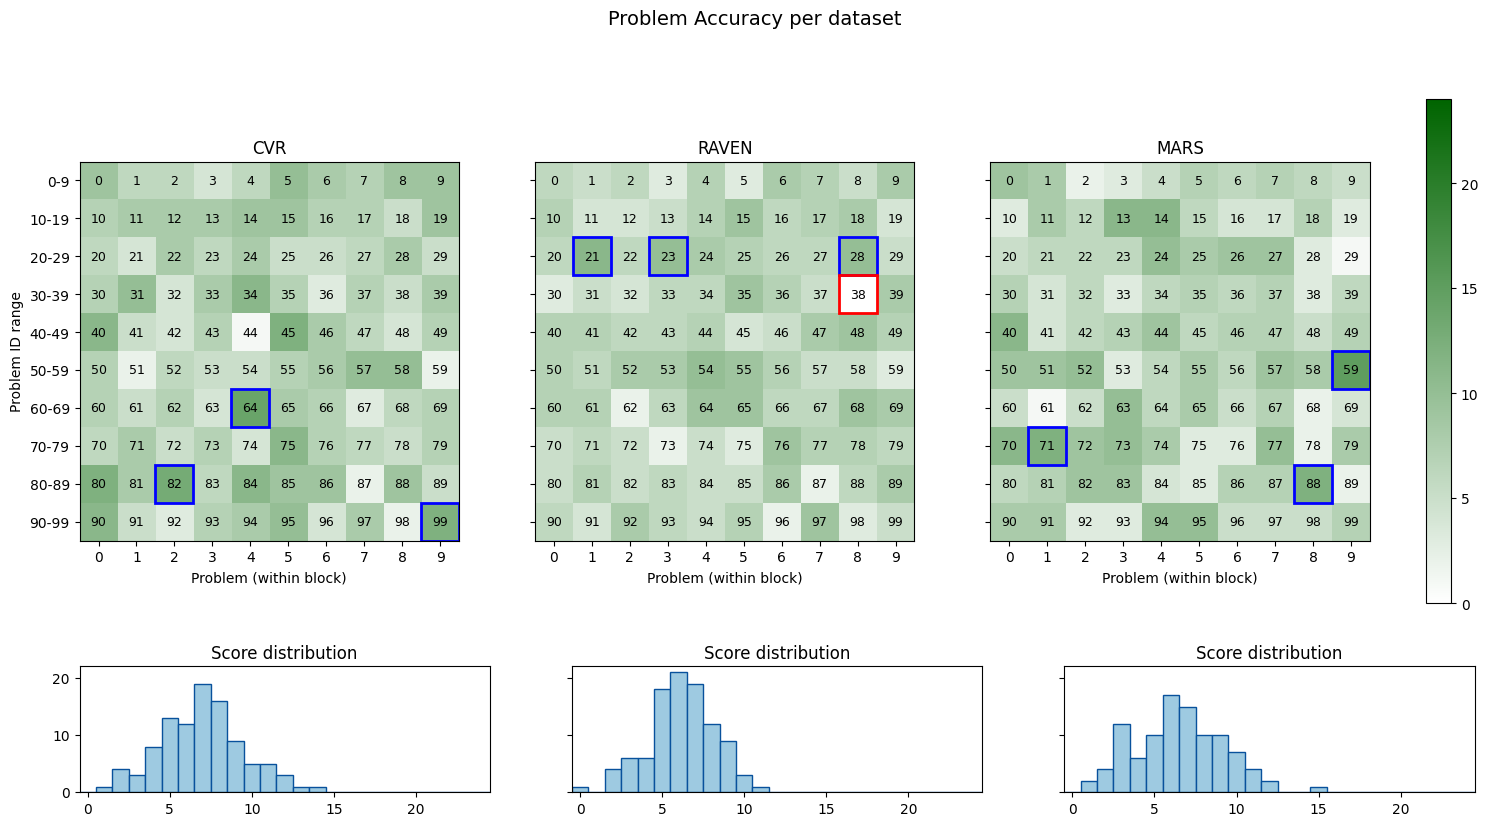

In [65]:
m1 = generate_10x10_result_matrix(df, dataset_name="cvr", zero_indexed_problem_ids=True)
m2 = generate_10x10_result_matrix(df, dataset_name="raven", zero_indexed_problem_ids=True)
m3 = generate_10x10_result_matrix(df, dataset_name="marsvqa", zero_indexed_problem_ids=True)
plot_10x10_matrices_side_by_side([m1,m2,m3],["CVR", "RAVEN", "MARS"],max_score=24, main_title="Problem Accuracy per dataset",highlight_extremes=True, zero_indexed_problem_ids=True)


BP
--
Zero-value problems : 0
  → None
Top 3 problems:
  → 42 : 22.0
  → 72 : 22.0
  → 47 : 22.5
Total score         : 1397 / 3600
Percentage achieved : 38.82%


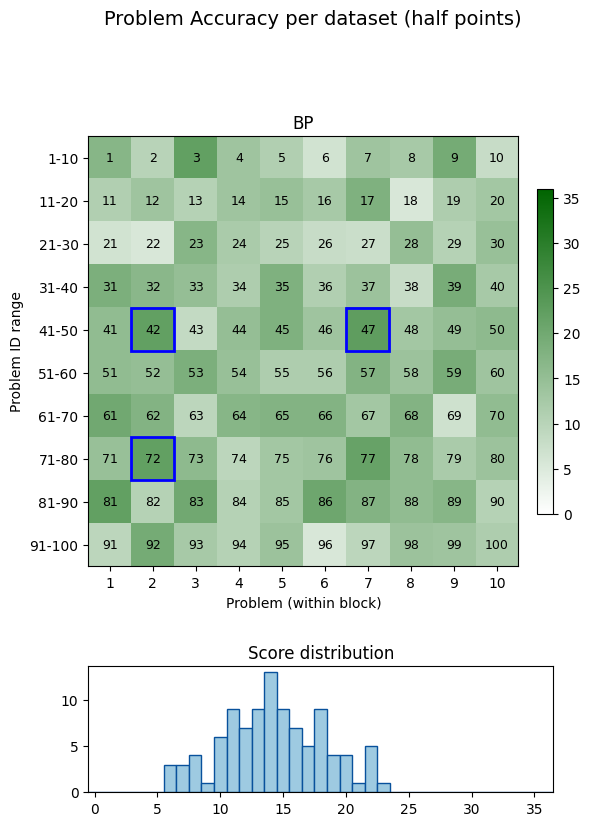

In [66]:
m1 = generate_10x10_result_matrix(df, dataset_name="bp")
plot_10x10_matrices_side_by_side([m1],["BP"],max_score=36, main_title="Problem Accuracy per dataset (half points)",highlight_extremes=True)

### Matrices - models


Qwen
----
Zero-value problems : 0
  → None
Top 3 problems:
  → 49 : 21.0
  → 23 : 22.0
  → 38 : 23.0
Total score         : 1377 / 3600
Percentage achieved : 38.26%

Intern
------
Zero-value problems : 0
  → None
Top 3 problems:
  → 8 : 18.5
  → 63 : 19.5
  → 85 : 19.5
Total score         : 1060 / 3600
Percentage achieved : 29.44%

Llava
-----
Zero-value problems : 0
  → None
Top 3 problems:
  → 13 : 13.5
  → 80 : 13.5
  → 24 : 14.0
Total score         : 900 / 3600
Percentage achieved : 25.00%


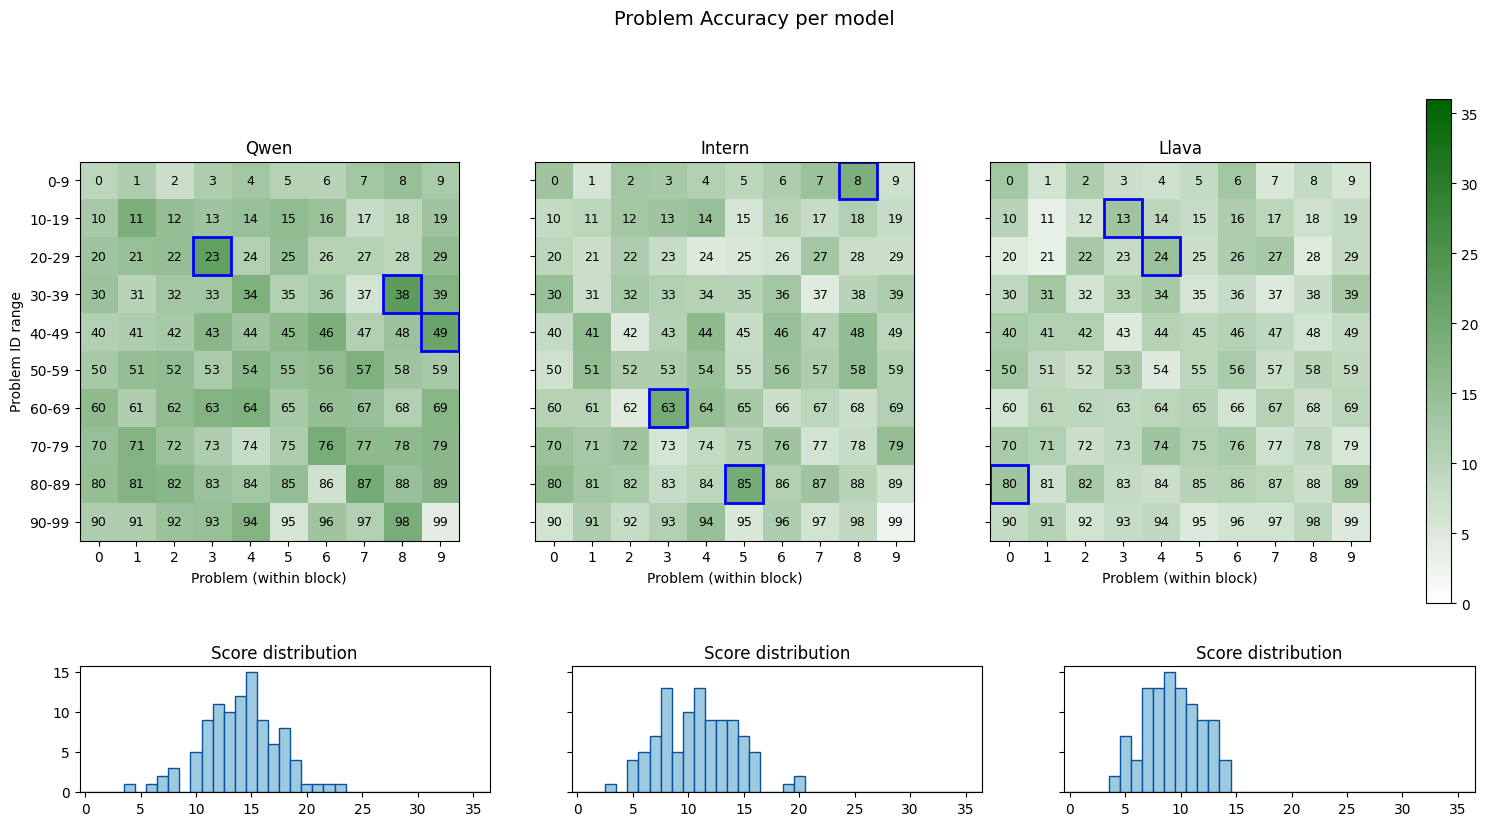

In [67]:
# 'Qwen/Qwen2.5-VL-7B-Instruct', 'llava-hf/llava-v1.6-mistral-7b-hf', 'OpenGVLab/InternVL3-8B'
m1 = generate_10x10_result_matrix(df, model_name="Qwen/Qwen2.5-VL-7B-Instruct")
m2 = generate_10x10_result_matrix(df, model_name="OpenGVLab/InternVL3-8B")
m3 = generate_10x10_result_matrix(df, model_name="llava-hf/llava-v1.6-mistral-7b-hf")
plot_10x10_matrices_side_by_side([m1,m2,m3],["Qwen", "Intern", "Llava"], max_score=36, main_title="Problem Accuracy per model",highlight_extremes=True, zero_indexed_problem_ids=True)